# Face detection

Firt step in face recognition pipeline is face detection.

We will use one of the fastest models - YOLOv5.

First - download from [official github repository](https://github.com/ultralytics/yolov5) and install all requirements.

In [1]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

fatal: destination path 'yolov5' already exists and is not an empty directory.
/mnt/4C2A3A002A39E81A/Google_d/2022_DL_Stepik/Face_Recognition/yolov5
Note: you may need to restart the kernel to use updated packages.


Usual imports.

In [2]:
%matplotlib inline
import torch
import cv2
import tqdm
import os
import cv2
import sys
import time
import mmcv
import shutil
import imghdr
import requests
import pandas as pd
import numpy as np
import utils
from tqdm.notebook import tqdm
from PIL import Image
display = utils.notebook_init()

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = 'w'
mpl.rcParams["axes.facecolor"] = 'w'
mpl.rcParams["savefig.facecolor"] = 'w'

fatal: unsafe repository ('/mnt/4C2A3A002A39E81A/Google_d/2022_DL_Stepik/Face_Recognition/yolov5' is owned by someone else)
To add an exception for this directory, call:

	git config --global --add safe.directory /mnt/4C2A3A002A39E81A/Google_d/2022_DL_Stepik/Face_Recognition/yolov5
YOLOv5 🚀 2022-6-20 Python-3.9.7 torch-1.11.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3060, 12031MiB)


Setup complete ✅ (20 CPUs, 62.5 GB RAM, 153.5/427.6 GB disk)


"Constants".

CelebA dataset is already downloaded to the ds_path.

The coco_ds_path dir is not created yet.

In [3]:
ds_path = '/home/sergey/DATASETS_ML/celebA_full/'
coco_ds_path = '/home/sergey/DATASETS_ML/celebA_coco/'
proj_path = os.path.dirname(os.getcwd())

# Prepare dataset

To use YOLO first we need to prepare the dataset. And by "prepare" I mean - to make it look like COCO dataset structure.

So first we'll join all annotations into one dataframe.

In [4]:
def get_annot_df(ds_path):
    
    bbox = mmcv.list_from_file(ds_path + 'Anno/list_bbox_celeba.txt')[1:]
    bbox = [i.split() for i in bbox]
    cols = bbox[0]
    bbox = bbox[1:]
    bbox = pd.DataFrame(bbox, columns=cols)
    bbox = bbox.set_index('image_id')
    bbox = bbox.astype(int)

    lmarks = mmcv.list_from_file(ds_path + 'Anno/list_landmarks_celeba.txt')[1:]
    lmarks = [i.split() for i in lmarks]
    cols = ['image_id'] + lmarks[0]
    lmarks = lmarks[1:]
    lmarks = pd.DataFrame(lmarks, columns=cols)
    lmarks = lmarks.set_index('image_id')
    lmarks = lmarks.astype(int)

    persons = mmcv.list_from_file(ds_path + 'Anno/identity_CelebA.txt')
    persons = [i.split() for i in persons]
    cols = ['image_id'] + persons[0]
    persons = pd.DataFrame(persons, columns=['image_id', 'person'])
    persons = persons.set_index('image_id')
    persons = persons.astype(int)
    
    partitions = mmcv.list_from_file(ds_path + 'Anno/list_eval_partition.txt')
    partitions = [i.split() for i in partitions]
    partitions = pd.DataFrame(partitions, columns=['image_id', 'part'])
    partitions = partitions.set_index('image_id')
    partitions = partitions.astype(int)

    return bbox.join([persons, lmarks, partitions]).reset_index(drop=False)

df = get_annot_df(ds_path)

Here is a function for test runs. It takes a stratified sample from a dataframe.

In [5]:
def get_stratified_sample(df, strat_col, N=100):
    return(
        df.groupby(strat_col, group_keys=False).apply(lambda x: x.sample(int(np.rint(N*len(x)/len(df))))).sample(frac=1).reset_index(drop=True)
    )

Check the function.

In [6]:
a = get_stratified_sample(df, 'part', N=2000)
a.part.value_counts()

0    1607
2     197
1     196
Name: part, dtype: int64

Let's look at some pictures and their annotations.

image_id        118519.jpg
x_1                    122
y_1                    140
width                  213
height                 295
person                9192
lefteye_x              188
lefteye_y              247
righteye_x             280
righteye_y             251
nose_x                 240
nose_y                 307
leftmouth_x            181
leftmouth_y            326
rightmouth_x           274
rightmouth_y           333
part                     0
Name: 118518, dtype: object


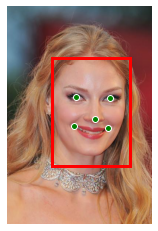

image_id        146109.jpg
x_1                    158
y_1                    133
width                  333
height                 461
person                8898
lefteye_x              260
lefteye_y              299
righteye_x             381
righteye_y             296
nose_x                 330
nose_y                 366
leftmouth_x            278
leftmouth_y            427
rightmouth_x           361
rightmouth_y           422
part                     0
Name: 146108, dtype: object


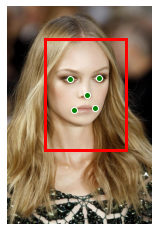

image_id        169250.jpg
x_1                    272
y_1                    238
width                  250
height                 346
person                3037
lefteye_x              349
lefteye_y              363
righteye_x             428
righteye_y             339
nose_x                 424
nose_y                 414
leftmouth_x            359
leftmouth_y            452
rightmouth_x           440
rightmouth_y           435
part                     1
Name: 169249, dtype: object


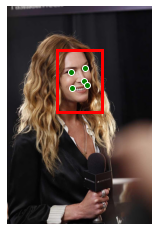

In [7]:
num_samples = 3

for i, row in enumerate(df.sample(num_samples).iterrows()):
    fig, ax = plt.subplots()
    b = row[1]
    print (b)
    src_file = ds_path + 'img_celeba/' + b['image_id']
    img = Image.open(src_file)
    plt.imshow(img)
    plt.axis('off')
    
    rect = mpl.patches.Rectangle((b['x_1'], b['y_1']), 
                                 b['width'], b['height'], 
                                 linewidth=3, edgecolor='r', facecolor='none')

    ax.add_patch(rect)
    x_list = [b['lefteye_x'], b['righteye_x'], b['nose_x'], b['leftmouth_x'], b['rightmouth_x']]
    y_list = [b['lefteye_y'], b['righteye_y'], b['nose_y'], b['leftmouth_y'], b['rightmouth_y']]
    plt.scatter(x=x_list, y=y_list, color='g', edgecolor='w',)
    plt.show()
    
    if i >= num_samples: break

Ok, everythin is working fine!

Now, for YOLO we need to specify bboxes as floats in range [0, 1] inside the picture. For that we need to read all pictures sizes. Here is a fuction to do this without reading the whole file.

In [8]:
def jpeg_res(filename):
   """"This function prints the resolution of the jpeg image file passed into it"""

   # open image for reading in binary mode
   with open(filename,'rb') as img_file:

       # height of image (in 2 bytes) is at 164th position
       img_file.seek(163)

       # read the 2 bytes
       a = img_file.read(2)

       # calculate height
       height = (a[0] << 8) + a[1]

       # next 2 bytes is width
       a = img_file.read(2)

       # calculate width
       width = (a[0] << 8) + a[1]

   return width, height

Another useful function.

In [9]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

And now we copy a lot of files...

In [10]:
create_dir(coco_ds_path)
for t in ['images/', 'labels/']:
    for p in ['train/', 'test/', 'val/']:
        create_dir(coco_ds_path + t + p)

# for debug use get_stratified_sample() like this:
# for idx in tqdm(range(len(get_stratified_sample(df, 'part', N=22)))): 

for idx in tqdm(range(len(df))):
    
    # row = get_stratified_sample(df, 'part', N=22).iloc[idx]
    row = df.iloc[idx]
    
    # train, val, test split
    part = row['part']
    if part == 0:
        part = 'train/'
    elif part == 1:
        part = 'val/'
    else:
        part = 'test/'
    
    # all file paths
    src_file = ds_path + 'img_celeba/' + row['image_id']
    dst_file = coco_ds_path + 'images/' + part + row['image_id']
    label_file = coco_ds_path + 'labels/' + part + row['image_id'].split('.')[0] + '.txt'
    
    # copy image
    shutil.copyfile(src_file, dst_file)
    
    # create straing for a label file
    x_m, y_m = jpeg_res(src_file)
    x_c = (row['x_1'] + row['width'] / 2) / x_m
    y_c = (row['y_1'] + row['height'] / 2) / y_m
    label = '0\t' + str(x_c) + '\t' + str(y_c) + '\t' 
    label += str(row['width'] / x_m) + '\t' + str(row['height'] / y_m)
    
    # write string to file
    with open(label_file, "w") as text_file:
        text_file.write(label)

  0%|          | 0/202599 [00:00<?, ?it/s]

And the last thing: we need to copy handmade yaml file to the dataset.

In [11]:
yaml_file = proj_path + '/tables/celeba.yaml'
shutil.copyfile(yaml_file, coco_ds_path+'celeba.yaml');

# Training

And now the magic.

In [12]:
%run train.py --img 640 --batch -1 --epochs 10 --data /home/sergey/DATASETS_ML/celebA_coco/celeba.yaml --weights yolov5s.pt

train: weights=yolov5s.pt, cfg=, data=/home/sergey/DATASETS_ML/celebA_coco/celeba.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=-1, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
YOLOv5 🚀 2022-6-20 Python-3.9.7 torch-1.11.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3060, 12031MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, s

Command 'git fetch && git config --get remote.origin.url' returned non-zero exit status 128.


Overriding model.yaml nc=80 with nc=1

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Conv                      [3, 32, 6, 2, 2]              
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  2    115712  models.common.C3                        [128, 128, 2]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  3    625152  models.common.C3                        [256, 256, 3]                 
  7                -1  1   1180672  models.common.Conv                      [256, 512, 3, 2]             

      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     7022326           0         0.292         10.16         20.41        (1, 3, 640, 640)                    list
     7022326           0         0.522         9.708         18.58        (2, 3, 640, 640)                    list
     7022326           0         0.998         13.51          28.6        (4, 3, 640, 640)                    list
     7022326           0         1.965         24.77          48.8        (8, 3, 640, 640)                    list


AutoBatch: Using batch-size 43 for CUDA:0 10.40G/11.75G (89%) ✅
Scaled weight_decay = 0.00033593750000000003
optimizer: SGD with parameter groups 57 weight (no decay), 60 weight, 60 bias
albumentations: Blur(always_apply=False, p=0.01, blur_limit=(3, 7)), MedianBlur(always_apply=False, p=0.01, blur_limit=(3, 7)), ToGray(always_apply=False, p=0.01), CLAHE(always_apply=False, p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


     7022326           0         3.899         48.04         99.47       (16, 3, 640, 640)                    list


train: Scanning '/home/sergey/DATASETS_ML/celebA_coco/labels/train.cache' images and labels... 162770 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 162770/162770 [00:00<?, ?it/s]
val: Scanning '/home/sergey/DATASETS_ML/celebA_coco/labels/val.cache' images and labels... 19867 found, 0 missing, 0 empty, 0 corrupt: 100%|██████████| 19867/19867 [00:00<?, ?it/s]
Plotting labels to runs/train/exp/labels.jpg... 

AutoAnchor: 3.63 anchors/target, 1.000 Best Possible Recall (BPR). Current anchors are a good fit to dataset ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/train/exp
Starting training for 10 epochs...

     Epoch   gpu_mem       box       obj       cls    labels  img_size
       0/9     9.64G   0.03038   0.01246         0        35       640: 100%|██████████| 3786/3786 [24:34<00:00,  2.57it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100%|██████████| 232/232 [01:07<00:00,  3.44it/s]
         

<Figure size 432x288 with 0 Axes>

# Training stats

In [12]:
res_dir = proj_path + '/yolov5/runs/train/exp/'

Lets look at used augmentations. Here is a training batch with GT bboxes.

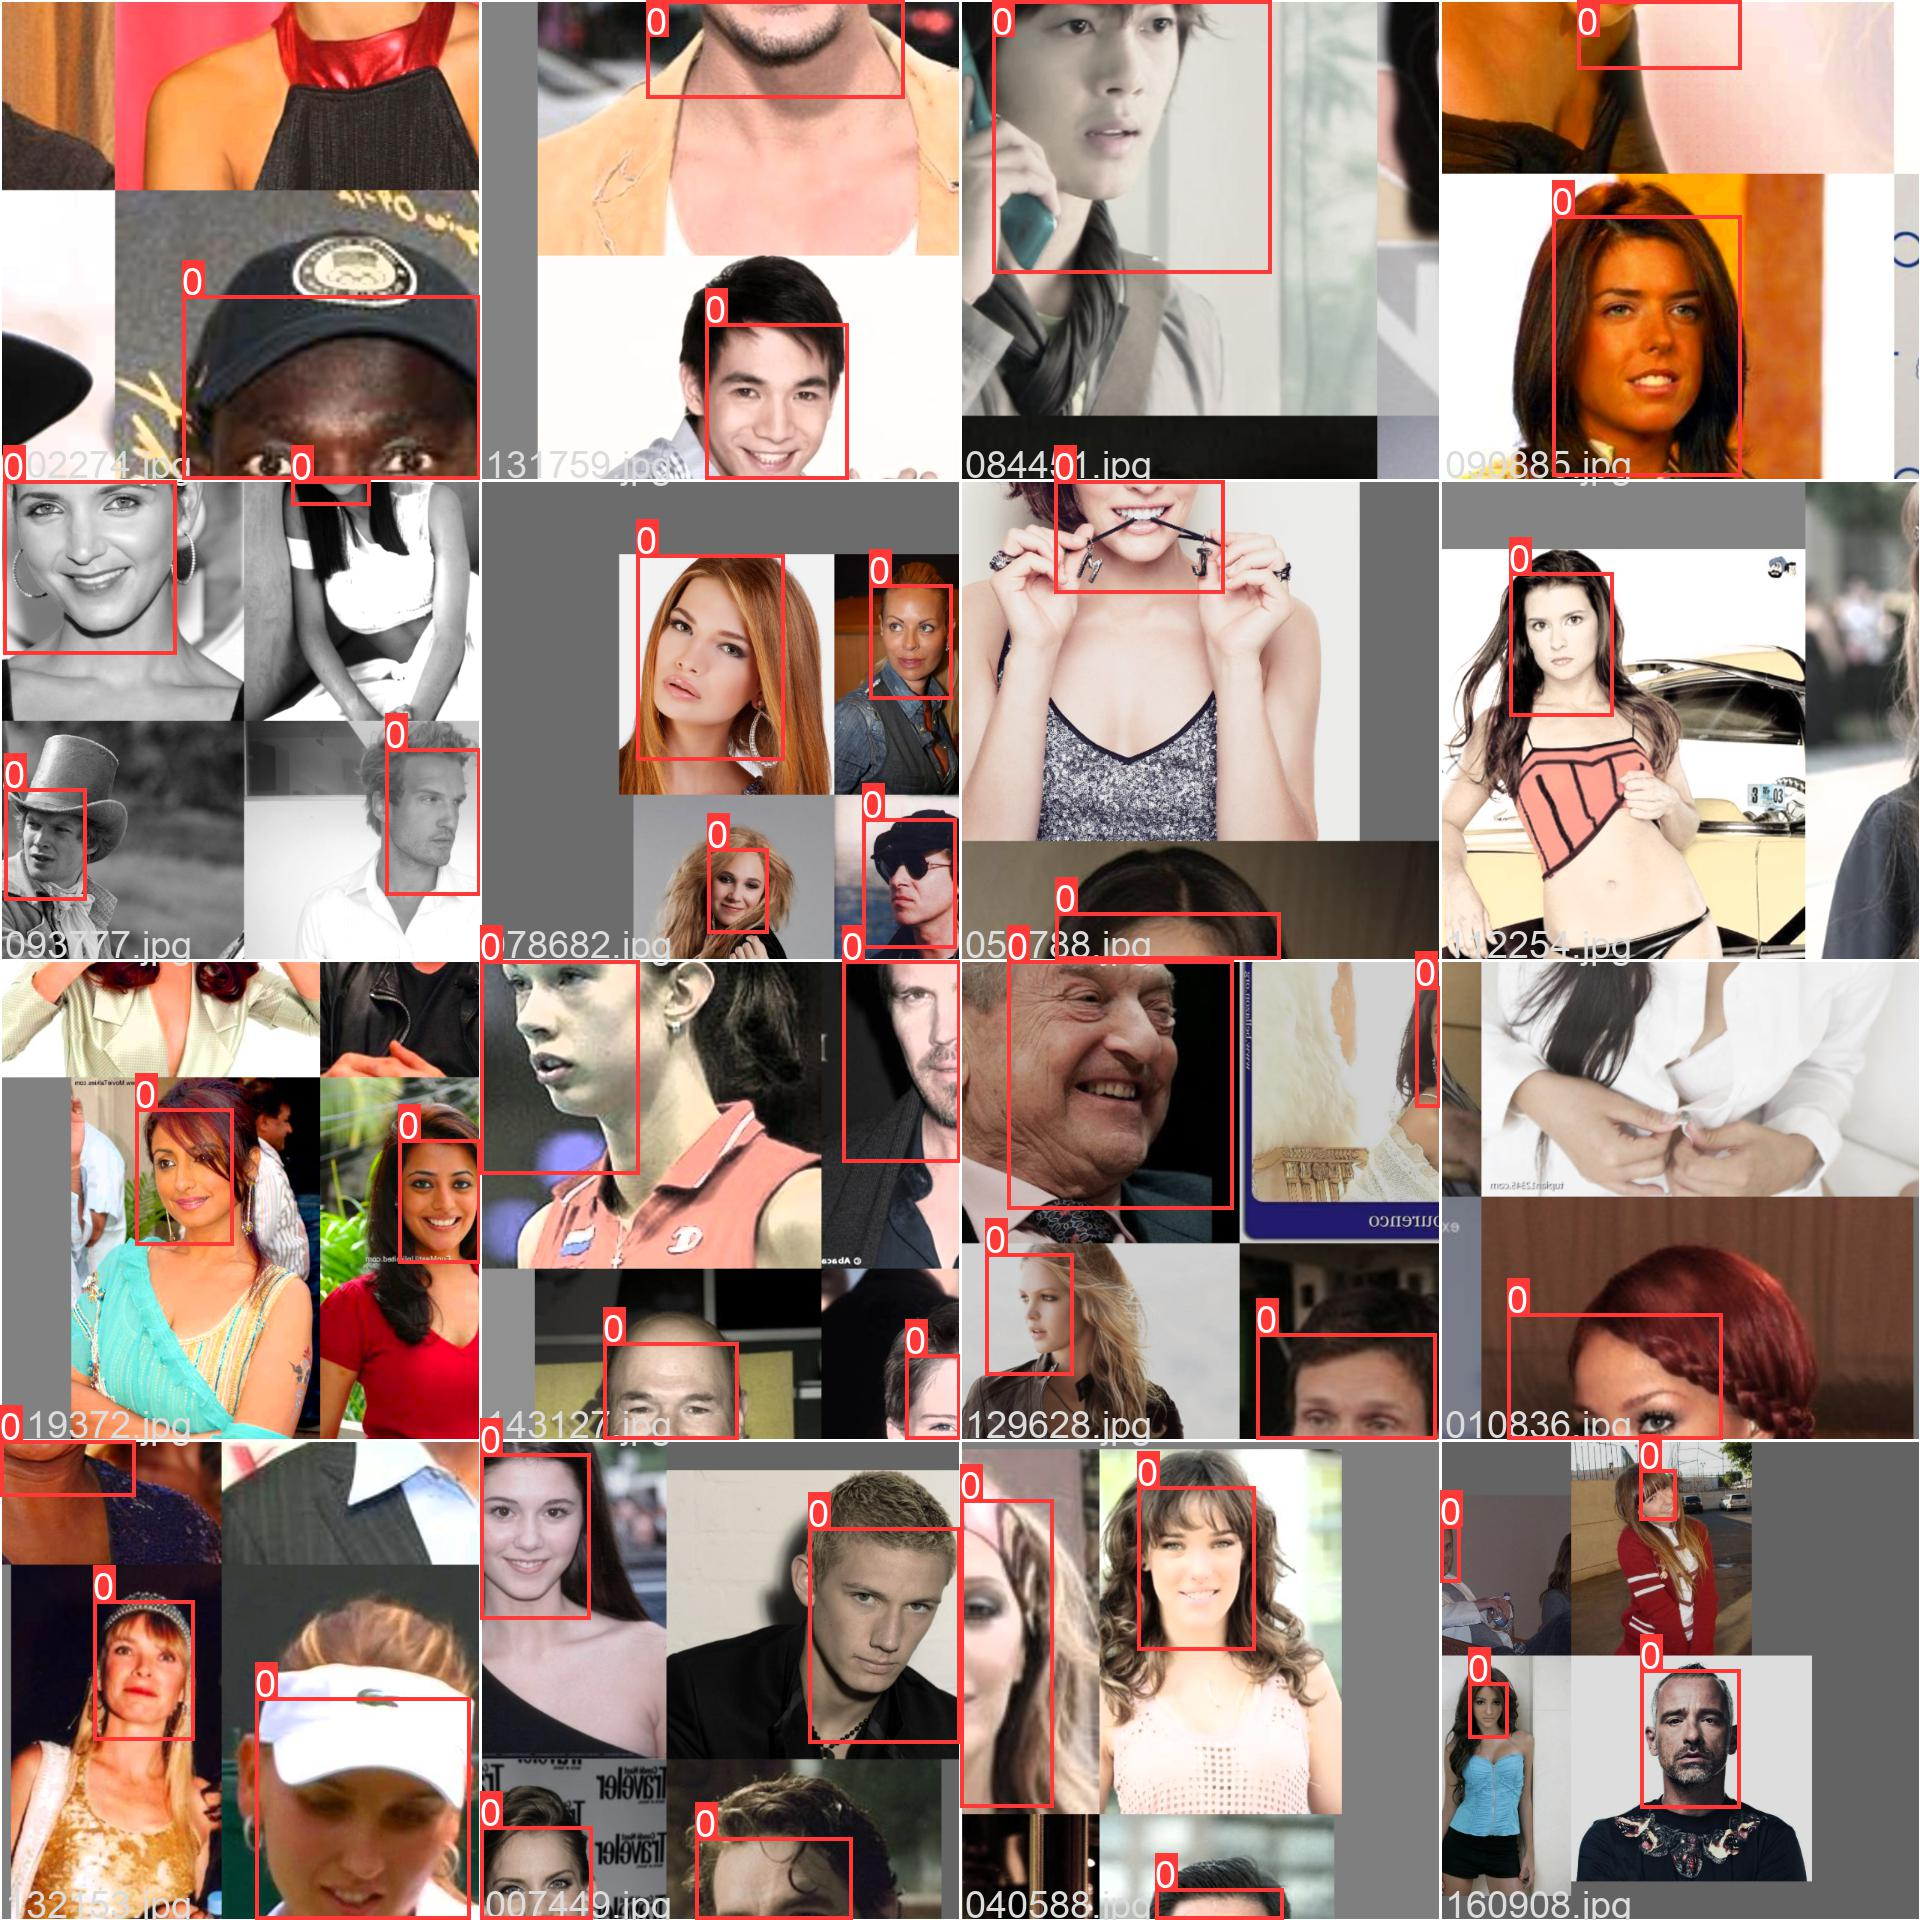

In [13]:
display.Image(res_dir+"train_batch0.jpg")

And here are predicted faces on validation set.

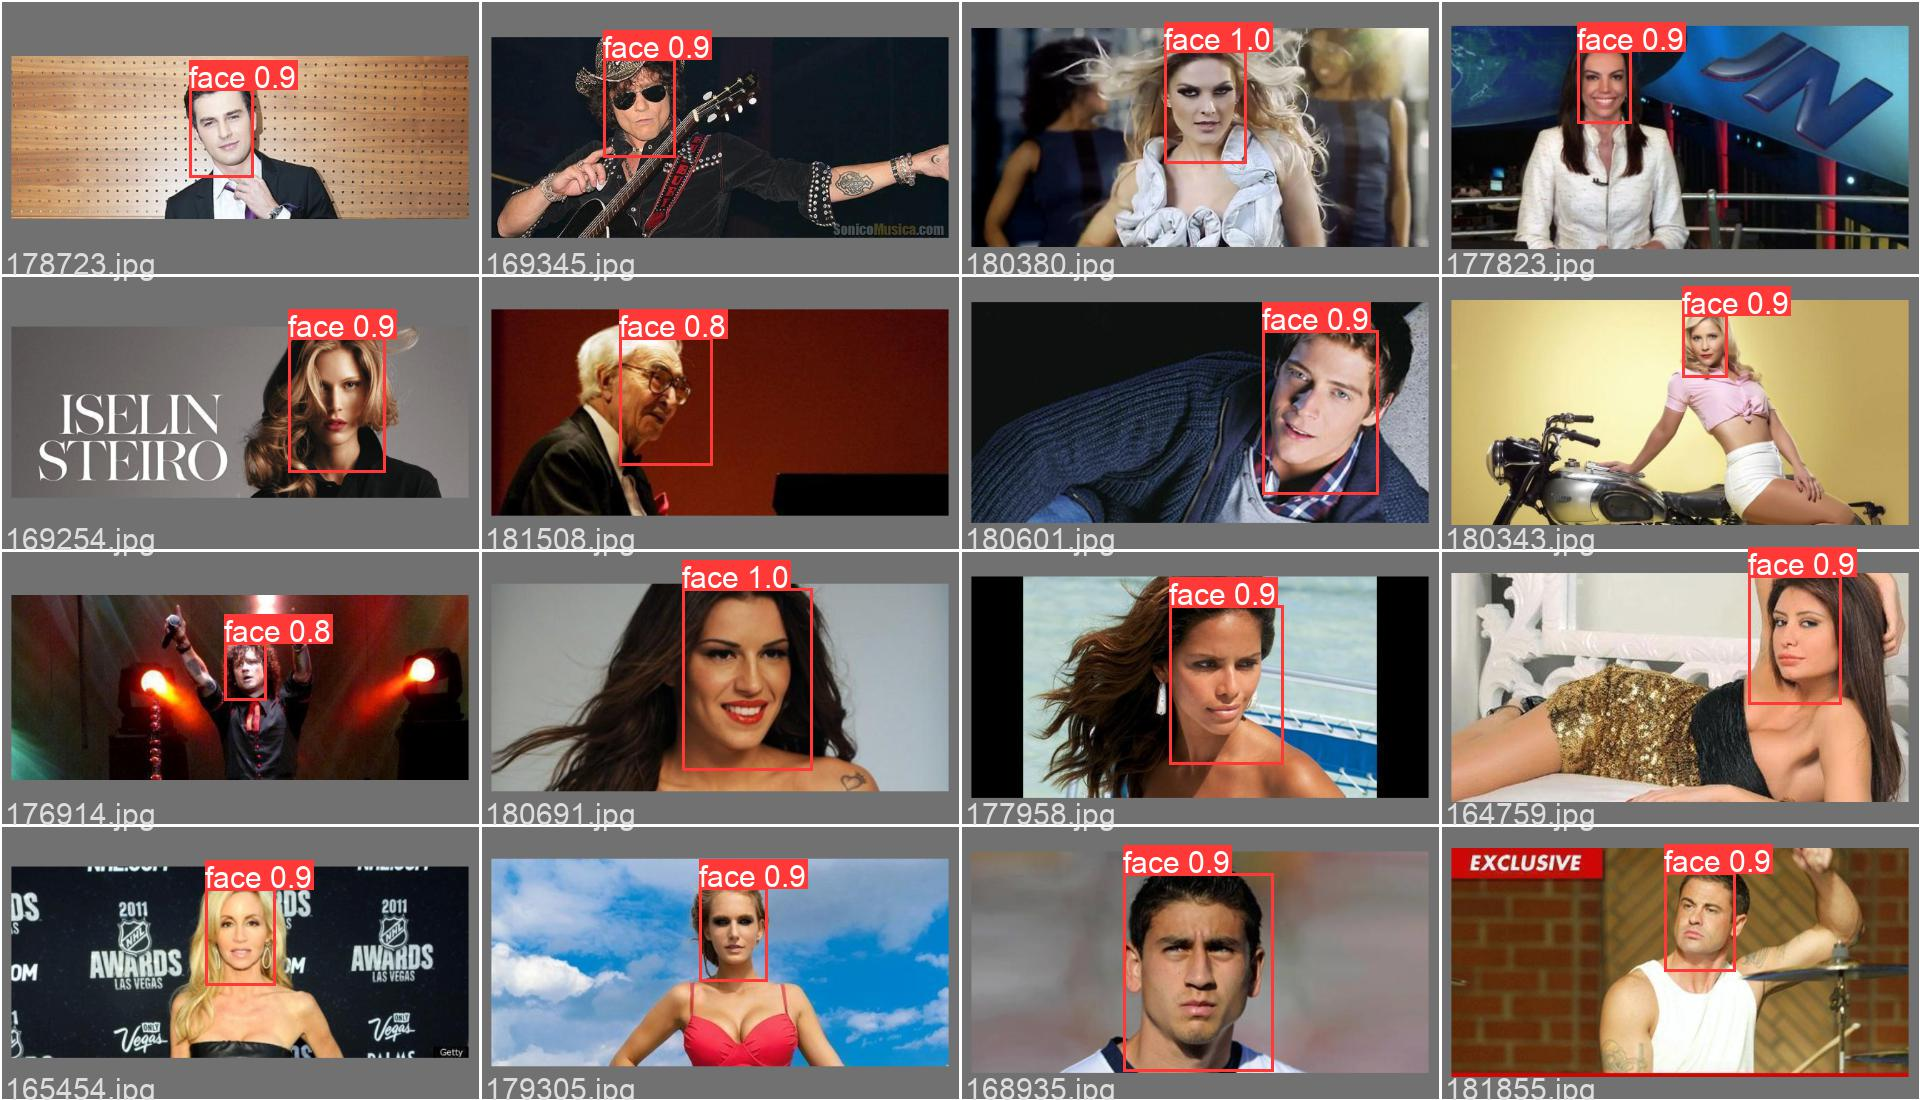

In [14]:
display.Image(res_dir+"val_batch0_pred.jpg")

Awesome!

Now lets look at training losses and metrics.

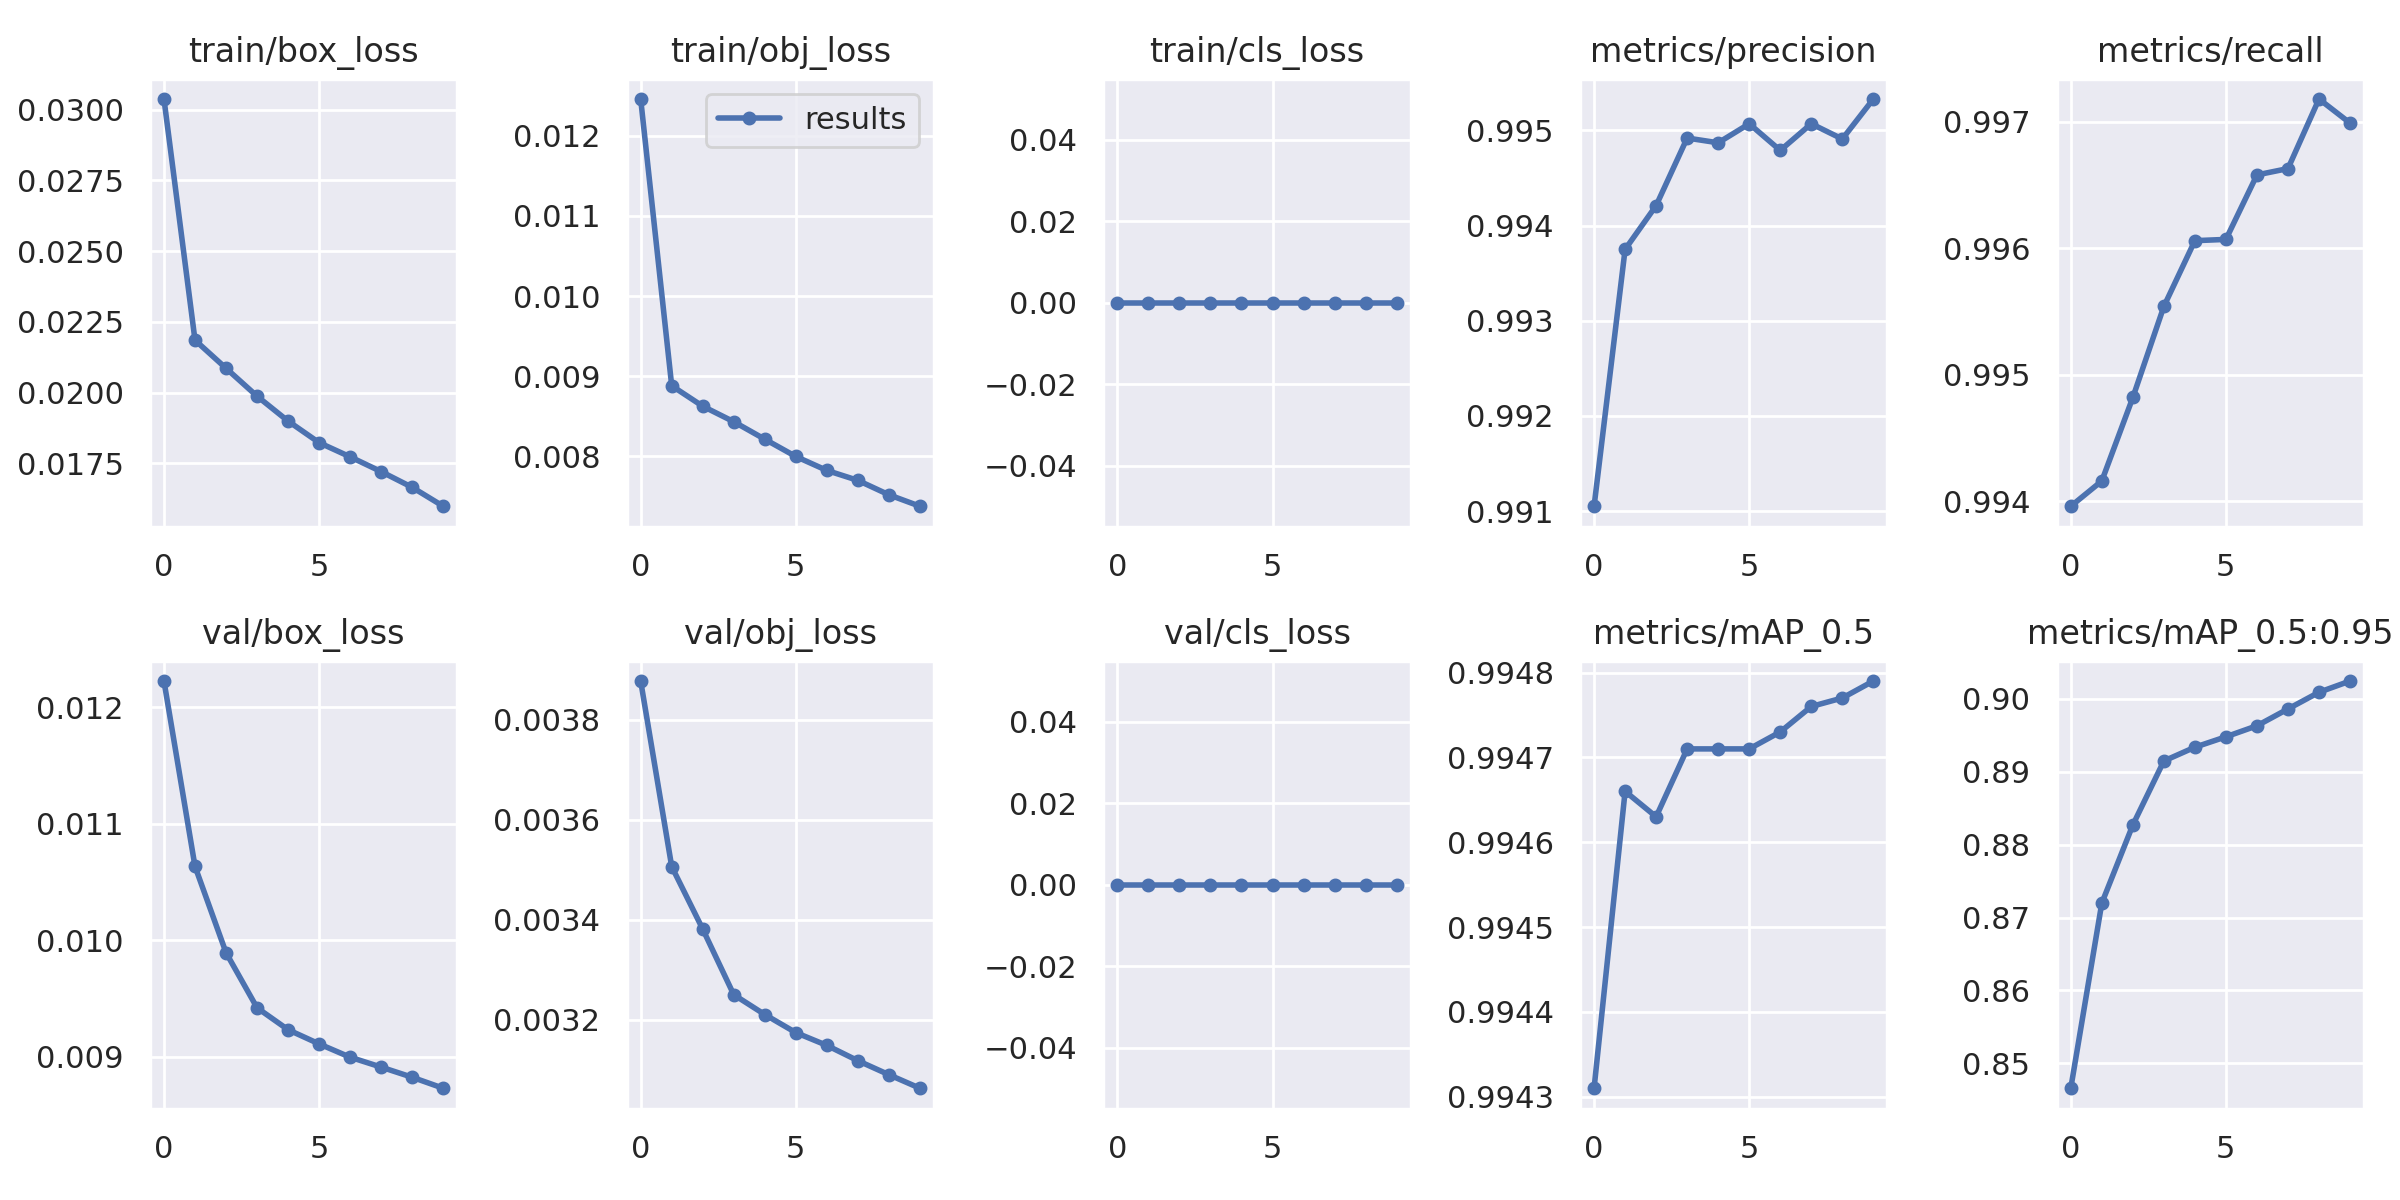

In [15]:
display.Image(res_dir+"results.png")

We have precision and recall > 0.995! Great.

# Inference

And what will happen if we try to use our model for some image from internet?

First we have to load the trained weights and put them into the model.

In [18]:
weigths_file = proj_path+'/models/detection/best.pt'
try:
    shutil.copyfile(weigths_file, proj_path+'/models/detection/best.pt');
except: pass

In [19]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path=weigths_file, force_reload=True, device='cpu')

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /home/sergey/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-6-20 Python-3.9.7 torch-1.11.0+cu113 CPU

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients
Adding AutoShape... 


And now inference time!

First lets run it and look at the resulting dataframe.

In [20]:
img = 'https://ultralytics.com/images/zidane.jpg' 
img = Image.open(requests.get(img, stream=True).raw)

In [21]:
# Inference
results = model(img)
# this command takes file, Path, PIL, OpenCV, numpy, list

# Results
results.print()
res_df = results.pandas().xyxy[0]
res_df

image 1/1: 720x1280 2 faces
Speed: 8.2ms pre-process, 84.9ms inference, 4.3ms NMS per image at shape (1, 3, 384, 640)


,xmin,ymin,xmax,ymax,confidence,class,name
0,907.577759,82.623276,1078.859131,318.860229,0.921440,0,face
1,553.805054,245.917450,714.452759,467.203461,0.353621,0,face


Now lets plot it.

/tmp/ipykernel_227574/2545738133.py:14: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


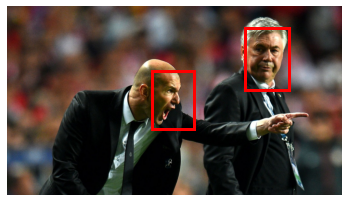

In [22]:
fig, ax = plt.subplots()
plt.imshow(img)
plt.axis('off')

for row in res_df.iterrows():
    row = row[1]
    xmin, ymin, xmax, ymax = (int(row['xmin']), int(row['ymin']), 
                              int(row['xmax']), int(row['ymax']))
    rect = mpl.patches.Rectangle((xmin, ymin), 
                                 xmax-xmin, ymax-ymin, 
                                 linewidth=3, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
plt.show()

It works.

Faster way to get result is to get a tensor directly.

In [23]:
results.xyxy[0]

tensor([[9.07578e+02, 8.26233e+01, 1.07886e+03, 3.18860e+02, 9.21440e-01, 0.00000e+00],
        [5.53805e+02, 2.45917e+02, 7.14453e+02, 4.67203e+02, 3.53621e-01, 0.00000e+00]])

In [24]:
results.xyxy[0].cpu().numpy()[:,:-2]

array([[     907.58,      82.623,      1078.9,      318.86],
       [     553.81,      245.92,      714.45,       467.2]], dtype=float32)

Also we can crop images directly to some dir.

In [25]:
crops = results.crop(save=True)

Saved 1 image to runs/detect/exp3
Saved results to runs/detect/exp3



# Webcam inference

/tmp/ipykernel_227574/12278722.py:33: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/tmp/ipykernel_227574/12278722.py:33: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


FPS 22.164121268469938


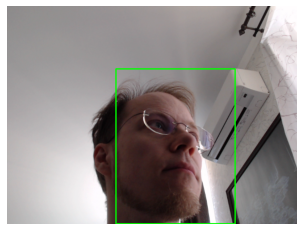

In [26]:
t_start = time.time()

try:
    video_capture.release()
except: pass

video_capture = cv2.VideoCapture(0)
frames = 0

while True:
    frames += 1
    # Capture frame-by-frame
    ret, frame = video_capture.read()
    
    results = model(frame)
    results = results.xyxy[0].cpu().numpy()[:,:-2]
    
    for row in results:
        row = row.astype(int)
        cv2.rectangle(frame, (row[0], row[1]), 
                      (row[2], row[3]), (0, 255, 0), 2)

    # Display the resulting frame
    cv2.imshow('Video', frame)

    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break
    elif key == ord('c'):
        RGB_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(RGB_img)
        plt.axis('off')
        plt.show()
        
# When everything is done, release the capture
video_capture.release()
cv2.destroyAllWindows()

t = time.time() - t_start
print('FPS', frames/t)

OK, everything works fine.

Next step - train landmarks coordiante detector (regressor).